# 📚  Exercise Histopathology Foundation Model

Exercise adapted from Charlotte Bunne, EPFL

This exercise needs to be run on a Modal notebook. 


- [Subtask 1.0: Get familiar with Histopathology images](#Subtask-1.0:-Get-familiar-with-Histopathology-images)
- [Subtask 1.1: Linear Probing based on FM embeddings](#task-11-linear-probing-based-on-fm-embeddings)
- [Subtask 1.2: Tissue-level classification](#task-12-tissue-level-classification)
- [Subtask 1.3: Whole-slide image analysis](#task-13-whole-slide-image-analysis)

## Task 1: Histopathology Foundation Models

In this task we are taking a look at one prominent area of Vision Foundation Models trained using DINOv2: Histopathology.
Since there is a bunch of different clincal "downstream" tasks on which one can possibly utilize large FMs, there is a variety of benchmarks available to, e.g., predict tumor (sub-)types, gene expressions within areas of the tissue, interesting Regions of Interest (ROIs). An overview of a few different and commonly used pathology models can be found here: https://birkhoffkiki.github.io/PathBench/. For this exercise, we are using the Phikon2 model.

In [1]:
!pip install torch transformers datasets Pillow umap-learn
!pip install s3fs tiffile imagecodecs zarr scikit-image
!pip install matplotlib seaborn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.6/47.6 MB 31.9 MB/s eta 0:00:00

[notice] A new release of pip is available: 24.3.1 -> 26.0
[notice] To update, run: pip install --upgrade pip
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.7/24.7 MB 45.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 55.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.2/9.2 MB 14.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.6/14.6 MB 58.6 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.6.1
    Uninstalling fsspec-2024.6.1:
      Successfully uninstalled fsspec-2024.6.1
  Attempting uninstall: aiosignal
    Found existing installation: aiosignal 1.3.1
    Uninstalling aiosignal-1.3.1:
      Successfully uninstalled aiosignal-1.3.1
  Attempting uninstall: aiohappyeyeballs
    Found existing installation: aiohappyeyeballs 2.4.3
    Uninstalling aiohappyeyeballs-2.4.3:
      Successfully uninstalled aioh

In [2]:
try:
    from umap.umap_ import UMAP
except ImportError:
    from umap import UMAP

In [3]:
from PIL import Image
import torch
from transformers import AutoImageProcessor, AutoModel
import matplotlib.pyplot as plt
from datasets import load_dataset
from tqdm import tqdm
import numpy as np

In [4]:
# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

<a id="task1.0"></a>

### Task 1.0: Getting familiar with Histopathology images.

**Histopathology background:** <br>
Histopathology is the microscopic examination of tissue samples to study the manifestations of disease. It is widely used in medical diagnosis to identify abnormalities such as cancer, inflammation, and infections. <br>
One of the fundamental staining techniques in histopathology is Hematoxylin and Eosin (H&E) staining. This method uses two dyes: hematoxylin and eosin. Hematoxylin stains cell nuclei a purplish-blue color, highlighting DNA and nuclear structures, while eosin stains the cytoplasm and extracellular matrix various shades of pink or red. The color contrast provided by H&E staining allows pathologists to easily differentiate cellular components and assess tissue architecture and pathological changes effectively. <br>
H&E staining is valued for its simplicity, cost-effectiveness, and ability to provide detailed visualization of tissue structure, making it the gold standard in histopathology laboratories globally. <br>

In the following, we are taking a look at H&E stains of lung tissue samples. More precisly, we are trying to label the lung cancer type of the H&E stains to distinguish between Lung adenocarcinoma (LUAD) and Lung squamous cell carcinoma (LUSC). 


In [5]:
ds_train = load_dataset("dakomura/tcga-ut", "internal", split="train", streaming=True) # if you get an error here, try setting streaming=False. This will download the dataset locally in advance.
ds_train = ds_train.filter(lambda sample: "Lung" in sample["json"]["label"])

ds_test = load_dataset("dakomura/tcga-ut", "internal", split="test", streaming=True)
ds_test = ds_test.filter(lambda sample: "Lung" in sample["json"]["label"])

README.md: 0.00B [00:00, ?B/s]

Resolving data files:   0%|          | 0/39 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/39 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/39 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/39 [00:00<?, ?it/s]

In [6]:
# Load phikon-v2
processor = AutoImageProcessor.from_pretrained("owkin/phikon-v2", use_fast=True)
model = AutoModel.from_pretrained("owkin/phikon-v2")
model.eval()
model.to(device)

Fetching 1 files:   0%|          | 0/1 [00:00<?, ?it/s]

preprocessor_config.json:   0%|          | 0.00/750 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/1.21G [00:00<?, ?B/s]

Dinov2Model(
  (embeddings): Dinov2Embeddings(
    (patch_embeddings): Dinov2PatchEmbeddings(
      (projection): Conv2d(3, 1024, kernel_size=(16, 16), stride=(16, 16))
    )
    (dropout): Dropout(p=0.0, inplace=False)
  )
  (encoder): Dinov2Encoder(
    (layer): ModuleList(
      (0-23): 24 x Dinov2Layer(
        (norm1): LayerNorm((1024,), eps=1e-06, elementwise_affine=True)
        (attention): Dinov2Attention(
          (attention): Dinov2SelfAttention(
            (query): Linear(in_features=1024, out_features=1024, bias=True)
            (key): Linear(in_features=1024, out_features=1024, bias=True)
            (value): Linear(in_features=1024, out_features=1024, bias=True)
          )
          (output): Dinov2SelfOutput(
            (dense): Linear(in_features=1024, out_features=1024, bias=True)
            (dropout): Dropout(p=0.0, inplace=False)
          )
        )
        (layer_scale1): Dinov2LayerScale()
        (drop_path): Identity()
        (norm2): LayerNorm((1024,),

In [8]:
def load_and_process_image(sample):
    image_bytes = sample["jpg"]
    # image = Image.open(io.BytesIO(image_bytes))
    image = image_bytes
    return {
        "image": image,
        "label": sample["json"]["label"],
        "patient_id": sample["__key__"][:12] # TCGA-XX-XXXX
    }

ds_train_processed = ds_train.map(load_and_process_image, remove_columns=["jpg", "json", "__key__", "__url__"])
ds_test_processed = ds_test.map(load_and_process_image, remove_columns=["jpg", "json", "__key__", "__url__"])


**Exercise 1**: Visualize some of the H&E samples of the dataset and display corresponding the labels and patient ids.

- Are histopathology images different from common images, e.g., as seen in the ImageNet-1k dataset? Yes, I think they are. Common images are generally situated in common / natural environments and  contain an object (like a vase, cat or car etc.). In contrast to that histopathology images are in the "microscopic" world and in this case stained to be able to view complex biological structures.

- If so, what implications would this have...
  
    - to data distributions? 
    Since histopathology images are special pink/purple continous textures, models trained on common images encounter a domains shift. Additionally, minor differences in lab protocols create "batch effects" that do not exist in standard images.
  
    - to general pre-trained FMs for RGB images? 
    These models were trained on common images, so they look for common patterns (like edges and eyes)... -> suboptimal for histopathology.
 
      
    - to data pre-processing? 
    First, these images are extremely high resolution, so it is necessary to break them into smaller segments (called patches or tiles). To handle lab to lab variability, it is often necessary to normalize the color distributions to a reference. Since histopathological images are continous textures, orientation does not matter and it is possible to apply augmentation techniques more aggressively than for common images.

Visualize some of the crops, print the label as well as as the patient id of the crop.

Sample 1:
  Patient ID: TCGA-55-8614
  Label: Lung_adenocarcinoma


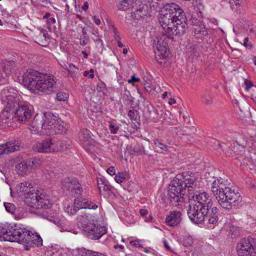

Sample 2:
  Patient ID: TCGA-55-8614
  Label: Lung_adenocarcinoma


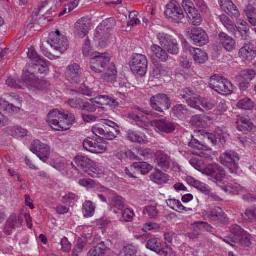

Sample 3:
  Patient ID: TCGA-71-8520
  Label: Lung_adenocarcinoma


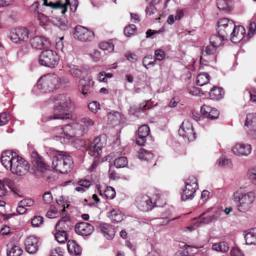

In [9]:
iter_ds = iter(ds_train_processed)

### YOUR CODE to visualize images here ###
# Hint: iterate over the data loader
# use display from IPython.display to show images in a Jupyter notebook
from IPython.display import display

num_to_view = 3
for i in range(num_to_view):
    try:
        sample = next(iter_ds)
        
        # Extract sample information
        patient_id = sample["patient_id"]
        label = sample["label"]
        image = sample["image"]
        
        print(f"Sample {i+1}:")
        print(f"  Patient ID: {patient_id}")
        print(f"  Label: {label}")
        
        # Display the image
        display(image)
        
    except StopIteration:
        print("No more samples available")
        break
iter_ds = iter(ds_train_processed)


<a name="task1.1"></a>

### Task 1.1: Linear Probing based on FM embeddings

**Exercise 2**: 
1. Embed the training crops, store the patient ids as well as the labels. 
2. Visualize the embeddings using a UMAP
3. Fit a Logistic Regression (LR) model on the training set
4. Embed the testset crops, and evaluate the LR using accuracy and F1-score.


In [11]:
ds_train_processed = ds_train_processed.with_format("torch")
ds_test_processed = ds_test_processed.with_format("torch")

BATCH_SIZE = 32
EMBEDDING_SIZE = 1024
NR_BATCHES = 100

dl_train = torch.utils.data.DataLoader(
    ds_train_processed,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=8,
)

In [12]:
embeddings = torch.zeros((BATCH_SIZE * NR_BATCHES, EMBEDDING_SIZE))
labels = []
patient_ids = []


model.eval()
with torch.inference_mode():
    with torch.autocast(device.type, torch.bfloat16):
        for i, batch in enumerate(tqdm(dl_train, total=NR_BATCHES)):
            inputs = processor(batch["image"], return_tensors="pt").to(device)
            ### YOUR CODE ###
            # Hint: use model to get embeddings
            outputs = model(**inputs)
            batch_embeddings = outputs.last_hidden_state[:, 0, :]
            outputs = model(**inputs)
            
            # Get the last hidden state and pool it to get a single embedding per image
            batch_embeddings = outputs.last_hidden_state[:, 0, :] 
            
            # Calculate indices
            start_idx = i * BATCH_SIZE
            end_idx = start_idx + batch_embeddings.shape[0]
            
            # Transfer to CPU and cast to float32 for sklearn
            embeddings[start_idx:end_idx] = batch_embeddings.cpu().float()
            
            labels.extend(batch["label"])
            patient_ids.extend(batch["patient_id"])

            if i == (NR_BATCHES - 1):
                break

 99%|████████████████████████████████████████████████████████████████████████▎| 99/100 [00:37<00:00,  2.61it/s]


**Exercise 3**:

Now that we have encoded our lung histopathology crops, visualize them in a UMAP.
Using the same umap embedding, color the plot once by patient ids and once by tumor type.

Create a second UMAP in which you visualize the embedded crops from only four patients, e.g. ['TCGA-33-4582', 'TCGA-55-8614', 'TCGA-77-8138', 'TCGA-71-8520'].

- What do you see in the UMAPs? 
  In the first visualization (all data), a high-density central region is observed where two distinct colors are heavily mixed. In the second visualization (specific patients), the data points are found to be much more sparse and are clearly grouped into four separate regions corresponding to individual patient IDs.
  
    - Are there overlapping classes?
    Yes, significant overlap is observed between the cancer types.
  
    - If so why, if not why not?
    Generic features, such as as stroma and supporting structures, are common to both tissue types and visible in the H&E sample, lead the model to generate similar embeddings for different malignancies. Due to these shared morphological traits at the microscopic level both cancer types are frequently mapped to the same coordinate space.

    - How nicely are the cancer types clustering? 
    The cancer types are observed to be clustered with limited success. While some "purity" is identified at the outer edges of the plot, the center is characterized by a high degree of intermingling. This suggests that the diagnostic label is not the primary driver of the variation captured in this specific embedding space.
     
    - Do we also see clustering in the patients? 
    Why could this be? Yes, clustering is observed to be significantly more distinct at the patient level. The reason could be the batch effect. Patches from the same patient cluster tightly together, which is attributed to technical factors, such as specific staining intensities or the scanner settings used for that individual's slide, which act as a so-called technical fingerprint.

/usr/local/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


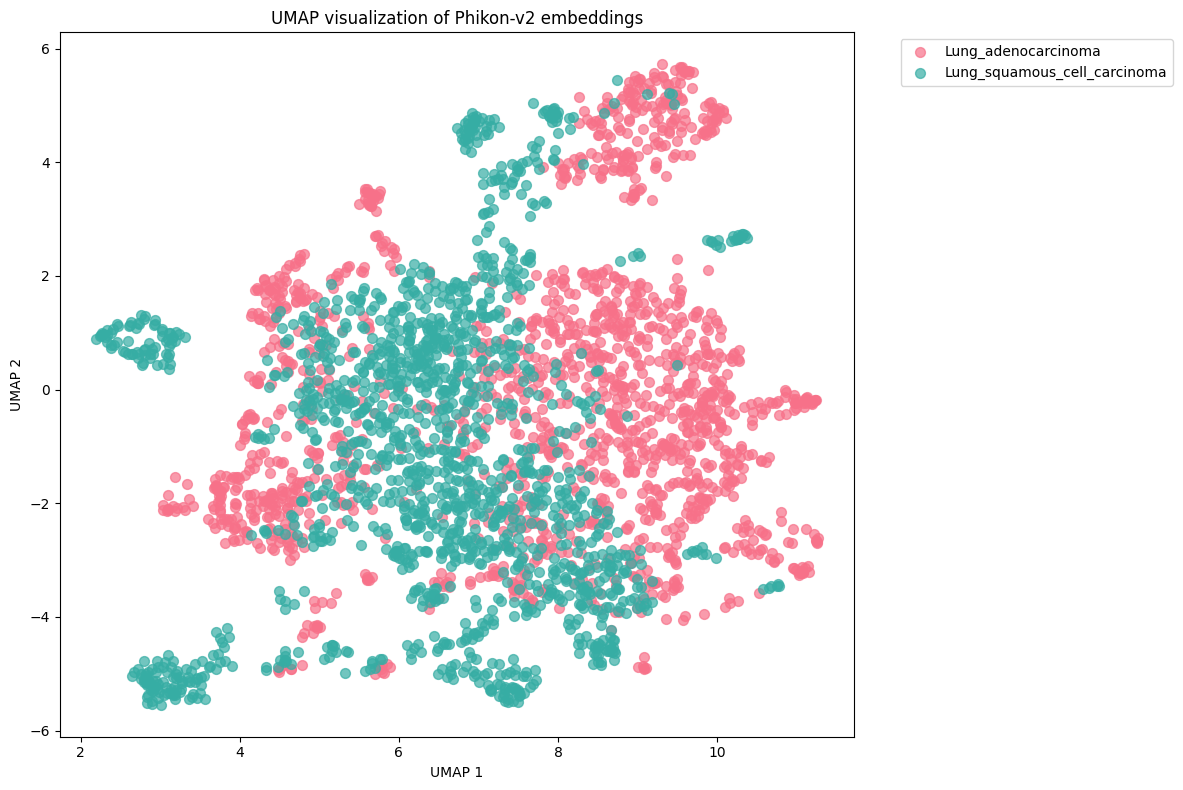

In [31]:
# Apply UMAP
import seaborn as sns
labels = np.array(labels)
patient_ids = np.array(patient_ids)

### YOUR CODE ###

# Use below snippet from the UMAP library
umap_reducer = UMAP(n_neighbors=30, min_dist=0.3, n_components=2, random_state=42)
embedding_2d = umap_reducer.fit_transform(embeddings)

# Create a plot
plt.figure(figsize=(12, 8))
unique_labels = np.unique(labels)
colors = sns.color_palette("husl", len(unique_labels))

for i, label in enumerate(unique_labels):
    mask = labels == label
    plt.scatter(embedding_2d[mask, 0], embedding_2d[mask, 1], 
                c=[colors[i]], label=label, alpha=0.7, s=50)

plt.xlabel('UMAP 1')
plt.ylabel('UMAP 2')
plt.title('UMAP visualization of Phikon-v2 embeddings')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


/usr/local/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/usr/local/lib/python3.12/site-packages/umap/umap_.py:2462: UserWarning: n_neighbors is larger than the dataset size; truncating to X.shape[0] - 1
  warn(


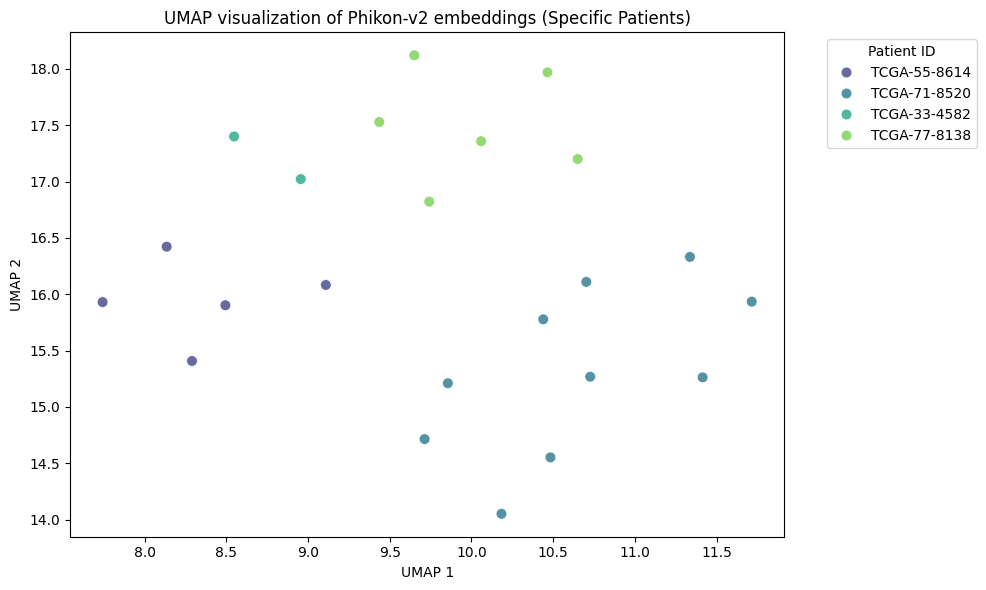

In [32]:
# List of patients to visualize
target_patients = ['TCGA-33-4582', 'TCGA-55-8614', 'TCGA-77-8138', 'TCGA-71-8520']

# Create a mask for these specific IDs
subset_mask = np.isin(patient_ids, target_patients)

# Filter embeddings and patient_ids
subset_embeddings = embeddings[subset_mask]
subset_patient_labels = patient_ids[subset_mask]

# Run UMAP on the subset
umap_subset = UMAP(n_neighbors=30, min_dist=0.3, n_components=2, random_state=42)
embedding_2d_subset = umap_subset.fit_transform(subset_embeddings)

# Plotting
plt.figure(figsize=(10, 6))
sns.scatterplot(
    x=embedding_2d_subset[:, 0], 
    y=embedding_2d_subset[:, 1], 
    hue=subset_patient_labels, 
    palette="viridis",
    alpha=0.8,
    s=60
)

plt.title('UMAP visualization of Phikon-v2 embeddings (Specific Patients)')
plt.xlabel('UMAP 1')
plt.ylabel('UMAP 2')
plt.legend(title='Patient ID', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

Now, we can do some logistic regression based on the FM embeddings to differentiate between Lung Adenocarcinoma (LUAD) and Lung Squamous Cell Carcinoma ( LUSC).

First, train a Logistic Regression classifier, afterwards embed the first 100 batches with a batch size of 32 of the test dataset defined above and calculate the accuracy as well as the f1-score on it. Additionally, save the patient ids for the next task.

In [16]:
from sklearn.linear_model import LogisticRegression

### YOUR CODE ###
X_train = embeddings.numpy()
y_train = np.array(labels)

# Use a logistic regression model from sklearn to classify the embeddings
clf = LogisticRegression(random_state=42, max_iter=1000)

# Train on the embeddings from the training set above and the labels
clf.fit(X_train, y_train)

,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,42
,solver,'lbfgs'
,max_iter,1000
,multi_class,'deprecated'


In [18]:
dl_test = torch.utils.data.DataLoader(
    ds_test_processed,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=8,
)

In [19]:
### YOUR CODE ###

## now do the same what you did to calculate embeddings for train set, but for test set

test_embeddings_list = []
test_labels = []
test_patient_ids = []

# Limit to 100 batches
NR_TEST_BATCHES = 100

model.eval()
with torch.inference_mode():
    with torch.autocast(device.type, torch.bfloat16):
        for i, batch in enumerate(tqdm(dl_test, total=NR_TEST_BATCHES)):
            if i >= NR_TEST_BATCHES:
                break
            
            # Process images
            inputs = processor(batch["image"], return_tensors="pt").to(device)
            outputs = model(**inputs)
            
            # Extract CLS token (index 0) and move to CPU/float32
            batch_emb = outputs.last_hidden_state[:, 0, :].cpu().float()
            
            test_embeddings_list.append(batch_emb)
            test_labels.extend(batch["label"])
            test_patient_ids.extend(batch["patient_id"])

100%|████████████████████████████████████████████████████████████████████████| 100/100 [02:04<00:00,  1.24s/it]



Test Results (Phikon-v2 + Logistic Regression):
Accuracy: 0.8922
F1-Score: 0.8921


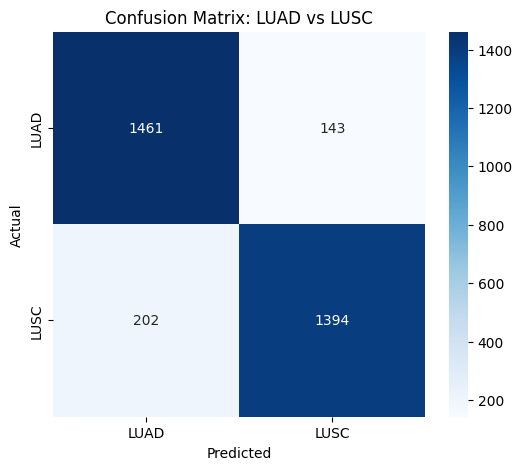

In [20]:
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

### YOUR CODE ###
X_test = torch.cat(test_embeddings_list, dim=0).numpy()
y_test = np.array(test_labels)
test_patient_ids = np.array(test_patient_ids)

# Use the trained logistic regression model to predict on the test embeddings
y_pred = clf.predict(X_test)

# Calculate accuracy, F1-score and confusion matrix
acc = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='macro')
conf_mat = confusion_matrix(y_test, y_pred)

print(f"\nTest Results (Phikon-v2 + Logistic Regression):")
print(f"Accuracy: {acc:.4f}")
print(f"F1-Score: {f1:.4f}")

plt.figure(figsize=(6, 5))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['LUAD', 'LUSC'], 
            yticklabels=['LUAD', 'LUSC'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix: LUAD vs LUSC')
plt.show()

<a id="task1.2"></a>


### Task 1.2: Tissue-level classification

Until now, we did everything on a crop level (256x256 pixels) extracted from a larger pathology whole slide that often spans more than 10,000 x 10,000 pixels.
As we are interested in a tissue-level and not crop level task, it would make more sense to derive predictions on a patient level.

We implement majority voting as a simple baseline to derive tissue-level prediction from the logisitic regression based test-set predictions





In [22]:
import pandas as pd

df = pd.DataFrame({"pid": test_patient_ids, "prediction": y_pred, "label": test_labels})
df_majority_voting = df.groupby("pid").agg({"prediction":pd.Series.mode, "label":"first"})

predictions_tissue = df_majority_voting["prediction"].values
labels_tissue = df_majority_voting["label"].values

# resolve ties
predictions_tissue = [p[0] if isinstance(p, np.ndarray) else p for p in predictions_tissue]

Now calculate tissue-level accuracies and f1-score.
- Would you expect improving performances? Why? 
Yes, because the aggregation of patches effectively filters out noise from non-diagnostic tissue. While individual patches of stroma or supporting structures may cause errors, their impact is reduced when the entire slide’s collective signal is analyzed. By using methods like majority voting, local misclassifications are suppressed in favor of the dominant pathological diagnosis. This approach minimizes the influence of microscopic artifacts and outliers that lead to the overlaps seen in patch-level UMAPs. That is why tissue-level metrics offer a more reliable and accurate measure of the model's true diagnostic capability.

Tissue-level Results (Majority Voting):
Accuracy: 0.9318
F1-Score: 0.9317

Classification Report:
              precision    recall  f1-score   support

        LUAD       0.90      0.97      0.93        66
        LUSC       0.97      0.89      0.93        66

    accuracy                           0.93       132
   macro avg       0.93      0.93      0.93       132
weighted avg       0.93      0.93      0.93       132



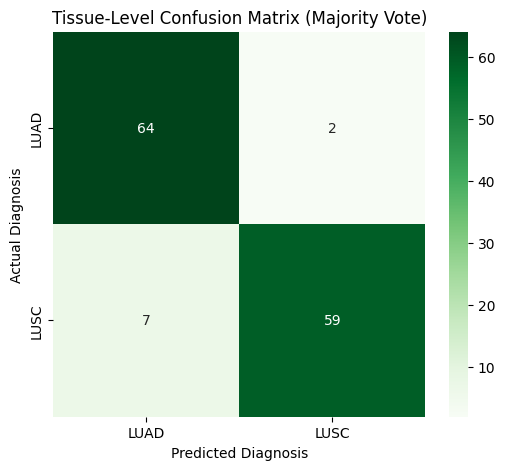

In [23]:
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

### YOUR CODE ###

# Calculate accuracy and macro F1-score for tissue-level predictions
tissue_accuracy = accuracy_score(labels_tissue, predictions_tissue)
tissue_f1 = f1_score(labels_tissue, predictions_tissue, average='macro')

print(f"Tissue-level Results (Majority Voting):")
print(f"Accuracy: {tissue_accuracy:.4f}")
print(f"F1-Score: {tissue_f1:.4f}")

# Precision/recall for LUAD vs LUSC specifically
print("\nClassification Report:")
print(classification_report(labels_tissue, predictions_tissue, target_names=['LUAD', 'LUSC']))

# Confusion Matrix
cm_tissue = confusion_matrix(labels_tissue, predictions_tissue)

plt.figure(figsize=(6, 5))
sns.heatmap(cm_tissue, annot=True, fmt='d', cmap='Greens',
            xticklabels=['LUAD', 'LUSC'], 
            yticklabels=['LUAD', 'LUSC'])
plt.xlabel('Predicted Diagnosis')
plt.ylabel('Actual Diagnosis')
plt.title('Tissue-Level Confusion Matrix (Majority Vote)')
plt.show()

<a id="task1.3"></a>


### Task 1.3: Whole-slide image analysis

So far we have taken a look at tissue-level downstream tasks where we were interested in global labels. We can also take a look at more local labels in a whole slide image (WSI).

In this task, we are using a WSI originating from a colorectal cancer (CRC) patient. A visualization of the WSI can be found [here](https://www.cycif.org/data/orion-crc/P37_S38-CRC10#s=0#w=0#g=5#m=-1#a=-100_-100#v=0.4618_0.8898_0.6185#o=-100_-100_1_1#p=Q).



In [24]:
import s3fs
import os

fs = s3fs.S3FileSystem(anon=True)
s3_path = 'lin-2023-orion-crc/data/CRC10/18459_LSP10452_US_SCAN_OR_001__091355-registered.ome.tif'

# Local filename to save the image
local_filename = 'crc10_he_wsi.ome.tif'

if not os.path.exists(local_filename):
    # Download the file from S3 to local filesystem
    fs.get(s3_path, local_filename)

print(f'Downloaded {local_filename}')

Downloaded crc10_he_wsi.ome.tif


Loading the image. To save some RAM and compute time, we only take a look at a 10,080 x 10,080 subpart of the WSI.

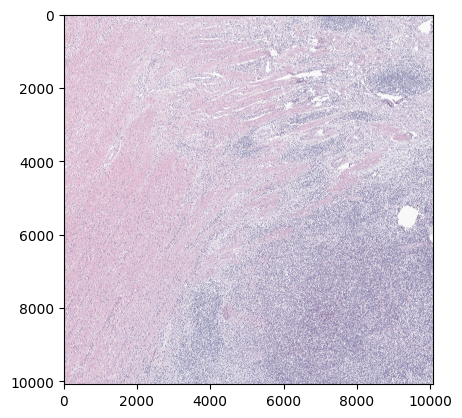

In [25]:
import tifffile

region = tifffile.imread(local_filename)
region = region[15000:25080, 5000:15080]
plt.imshow(region)

Now, embed the tissue by iterating over the image using a crop size of 224x224 without overlap, store the cls tokens and the local patch tokens of each of the crops.

Afterwards, take the top left and the bottom right cls embedding as well as the mean of local patch embeddings of the top left as well as bottom right crop. These will serve as "prototypes". Cacluate the cosine similarities between all cls tokens and the cls-based prototypes and the patches and the patch-based prototypes, respectively.

Hint: the patch size of the Phikon2 model is 16x16.

**Exercise 4**:
1. Implement the sliding window embedding 
2. Calculate cosine similarities of a prototype of the image and all other embeddings
3. Visualize the cosine similarities

In [26]:
CROP_SIZE = 224
PATCH_SIZE = 16
NUM_PATCHES = CROP_SIZE // PATCH_SIZE  # 14
EMBEDDING_SIZE = model.config.hidden_size

embeddings_cls = torch.zeros((45, 45, EMBEDDING_SIZE))
embeddings_ps  = torch.zeros((630, 630, EMBEDDING_SIZE))

region_x, region_y = region.shape[:2]

# Total number of crops
total_crops = 45 * 45

with torch.inference_mode():
    with torch.autocast(device.type, torch.bfloat16):
        # Wrap outer loop in tqdm
        for x in tqdm(range(45), desc="Processing rows"):
            for y in range(45):
                # Extract the 224x224 crop
                crop = region[x*CROP_SIZE:(x+1)*CROP_SIZE, y*CROP_SIZE:(y+1)*CROP_SIZE]

                inputs = processor(crop, return_tensors="pt").to(device)
                outputs = model(**inputs)

                cls_tokens = outputs.last_hidden_state[:, 0, :].cpu().float()
                embeddings_cls[x, y] = cls_tokens

                patch_tokens = outputs.last_hidden_state[:, 1:, :].cpu().float()
                patch_tokens = patch_tokens.reshape(NUM_PATCHES, NUM_PATCHES, EMBEDDING_SIZE)

                embeddings_ps[x*NUM_PATCHES:(x+1)*NUM_PATCHES, y*NUM_PATCHES:(y+1)*NUM_PATCHES] = patch_tokens

Processing rows: 100%|█████████████████████████████████████████████████████████| 45/45 [05:06<00:00,  6.80s/it]


In [27]:
import torch
import torch.nn.functional as F

# Example Top left token
# For the cls tokens first
cls_00 = embeddings_cls[0, 0]  # shape: (EMBEDDING_SIZE,)
cls_00 = cls_00.unsqueeze(0)  # shape: (1, EMBEDDING_SIZE)

vectors_all_cls = embeddings_cls.view(-1, embeddings_cls.shape[2])
cosine_sim_cls_00 = F.cosine_similarity(cls_00, vectors_all_cls, dim=1)
cosine_sim_cls_00 = cosine_sim_cls_00.reshape(embeddings_cls.shape[:2])

# For the ps tokens 
ps_00 = embeddings_ps[0, 0]  # shape: (EMBEDDING_SIZE,)
ps_00 = torch.mean(embeddings_ps[:14, :14], dim=(0,1))
ps_00 = ps_00.unsqueeze(0)  # shape: (1, EMBEDDING_SIZE)

vectors_all_ps = embeddings_ps.view(-1, embeddings_ps.shape[2])
cosine_sim_ps_00 = F.cosine_similarity(ps_00, vectors_all_ps, dim=1)
cosine_sim_ps_00 = cosine_sim_ps_00.reshape(embeddings_ps.shape[:2])

# Add bottom right 
# For the cls tokens 
cls_nn = embeddings_cls[44, 44]  # shape: (EMBEDDING_SIZE,)
cls_nn = cls_nn.unsqueeze(0)  # shape: (1, EMBEDDING_SIZE)

cosine_sim_cls_nn = F.cosine_similarity(cls_nn, vectors_all_cls, dim=1)
cosine_sim_cls_nn = cosine_sim_cls_nn.reshape(embeddings_cls.shape[:2])

# For the ps tokens
# Note: -14: represents the last 14 patches (the bottom right crop)
ps_nn = torch.mean(embeddings_ps[-14:, -14:], dim=(0,1))
ps_nn = ps_nn.unsqueeze(0)  # shape: (1, EMBEDDING_SIZE)

cosine_sim_ps_nn = F.cosine_similarity(ps_nn, vectors_all_ps, dim=1)
cosine_sim_ps_nn = cosine_sim_ps_nn.reshape(embeddings_ps.shape[:2])

Visualize the cosine similarities on top of the image between the selected prototypes and all other embeddings (once for the cls tokens, once for the patch tokens).

- What do you observe?
CLS tokens capture global tissue patterns, while patch tokens highlight precise local structures.

- What could this be useful for in a clinical setting?
They help pathologists verify model focus and avoid distractions from artifacts. High-similarity regions enable automated triage, guiding clinicians to suspicious areas quickly. Comparing tissues to prototypes provides objective, reproducible disease grading. These maps also support biomarker discovery, revealing patterns linked to survival or treatment response.

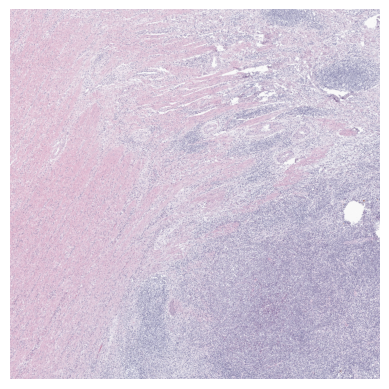

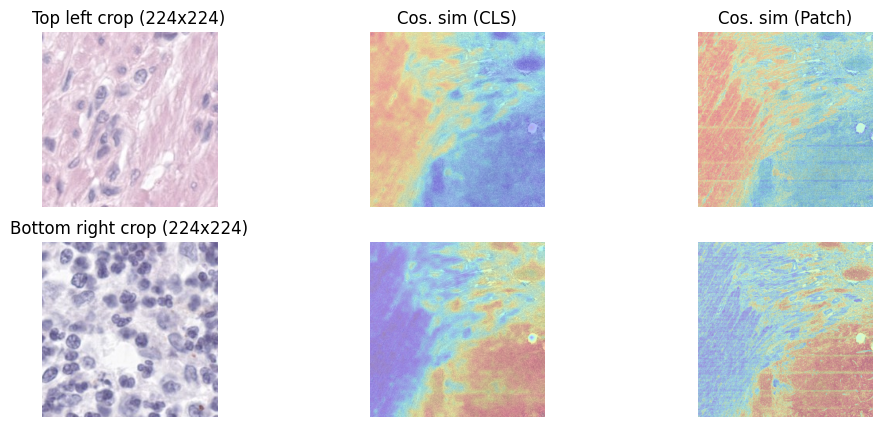

In [29]:
from skimage.transform import resize



cosine_sim_cls_00_resized = resize(cosine_sim_cls_00.cpu().numpy().astype(np.float32), (region_x, region_y))
cosine_sim_cls_nn_resized  = resize(cosine_sim_cls_nn.cpu().numpy().astype(np.float32), (region_x, region_y))

cosine_sim_ps_00_resized   = resize(cosine_sim_ps_00.cpu().numpy().astype(np.float32), (region_x, region_y))
cosine_sim_ps_nn_resized   = resize(cosine_sim_ps_nn.cpu().numpy().astype(np.float32), (region_x, region_y))



plt.imshow(region[::10, ::10])
plt.axis('off')
plt.show()

fig, axs = plt.subplots(2,3, figsize=(12, 5))
axs = axs.flatten()
axs[0].imshow(region[:224, :224])
axs[0].set_title("Top left crop (224x224)")
axs[1].imshow(region[::10, ::10])
axs[1].imshow(cosine_sim_cls_00_resized[::10, ::10], alpha=0.3, cmap="jet")
axs[2].imshow(region[::10, ::10])
axs[2].imshow(cosine_sim_ps_00_resized[::10, ::10], alpha=0.3, cmap="jet")
axs[3].imshow(region[-224:, -224:])
axs[3].set_title("Bottom right crop (224x224)")
axs[4].imshow(region[::10, ::10])
axs[4].imshow(cosine_sim_cls_nn_resized[::10, ::10], alpha=0.3, cmap="jet")
axs[5].imshow(region[::10, ::10])
axs[5].imshow(cosine_sim_ps_nn_resized[::10, ::10], alpha=0.3, cmap="jet")

axs[1].set_title("Cos. sim (CLS)")
axs[2].set_title("Cos. sim (Patch)")

for ax in axs:
    ax.axis('off')